# Proyecto Final Aprendizaje de Máquina
## Reinforcement Learning - Q Learning
## Deep Q-Learning
- Jose Ulises Quevedo 189442
- Javier Orcazas 192100
- Sebastián Dulong 188172

El siguiente programa resuelve el problema de la librería **gym** conocido como **mountain car**. El objetivo del juego es llevar el carrito a la cima de la montaña acelerando hacia la derecha o hacia la izquierda. El siguiente progrrama estima la función `q(s,a)` que recibe un estado y una acción, tal que la política optima escoge *a* tal que maximiza `q(s,a)` para todo s


Algunos puntos importantes:
- **Agente**: El carrtio. Toma decisiones
- **Ambiente**: La colina. Sus estados están dados por la posición y velocidad del carrito
- **Rewards**: `-1` por cada instante que no está en la cima de la colina, `10` por llegar arriba de la colina. Así, el objetivo del agente es llegar a la colina lo más rápido posible.
- **Acciones**: Derecha, Izquierda o no moverse

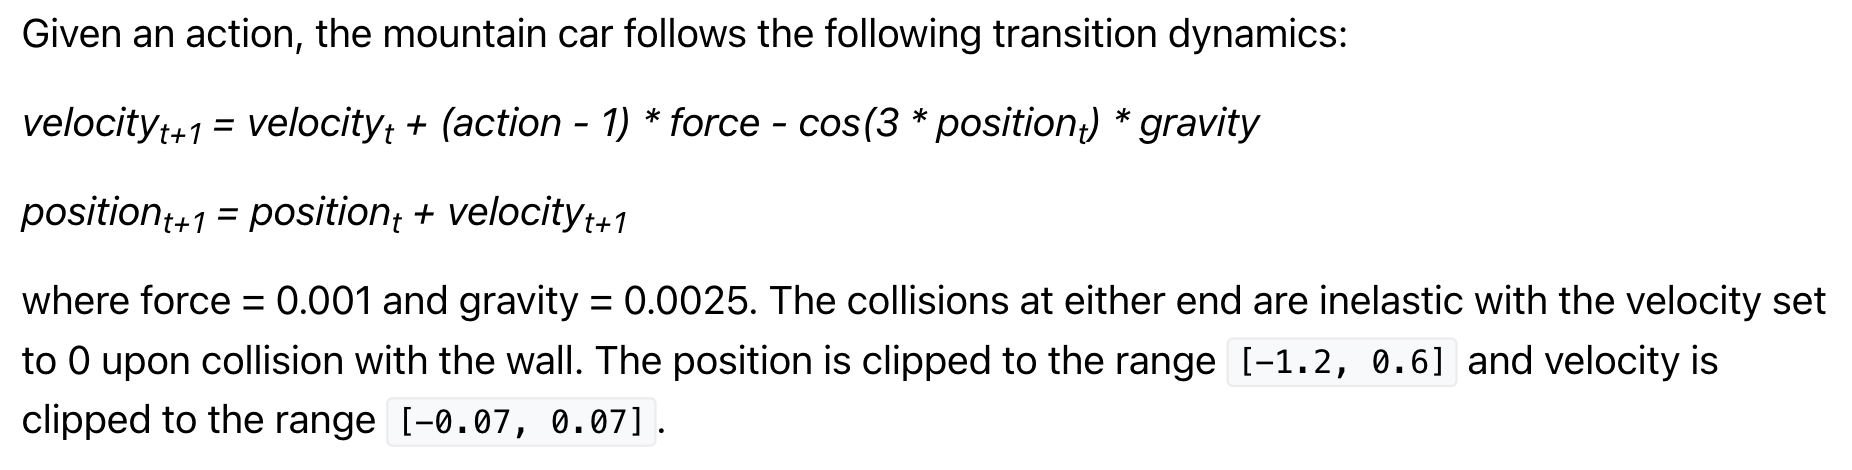


## 1. Librerías

- Usamos **keras**/**tensorflow** para entrenar la red neuronal

- Usamos la librería **gym** para cargar las cosas

In [130]:
import gym
from keras import models

from keras import layers
from tensorflow.keras.optimizers import Adam
from collections import deque
import math
import matplotlib.pyplot as plt
import matplotlib
import random
import numpy as np

is_ipython = "inline" in matplotlib.get_backend()
if is_ipython: from IPython import display
    
from numpy.random import seed 
seed(42)# keras seed fixing 
import tensorflow as tf 
tf.random.set_seed(42)


## 2. Red Neuronal

Nuestra red es una red de 3 layers (más uno de entrada). 
- Recibe un vector de tamaño 2 (posición y velocidad), estos pasan a un layer de 24 neuronas (fully connected), de ahí a un layer de 48 neuronas y de ahí a un layer de salida de tamaño 3 (que representa las tres acciones: izquierda, derecha y quieto). 
- La activación de los layers intermedios es **ReLu** y del último es **lineal**. 
- Usa el **Mean Squared Error** para calcular el error, **Adam** como optimizer

In [23]:
def DQN(env):
    

    model = models.Sequential()
    state_shape = env.observation_space.shape
    
    model.add(layers.Dense(24,activation='relu',input_shape=state_shape))
    model.add(layers.Dense(48,activation='relu'))
    model.add(layers.Dense(env.action_space.n,activation='linear'))
    
    model.compile(loss='mse', optimizer=Adam(learning_rate=lr))
    
    
    return model
    


    

## 3. ε - Greedy Strategy

Usamos una estrategia ε greedy. Cuando tenemos que tomar una acción, tomamos una al azar con probabilidad ε, y en los otros casos tomamos la acción óptima según nuestra política.


La estrategia está parametrizada por los siguientes parámetros:
- start: el valor inicial de ε. Por lo general es 1
- end: el valor final de ε. El valor más chico que puede tomar, puede ser 0, o un valor muy pequeño
- decay: cuánto se reduce el valor de ε cada que se reduce


La idea es que al inicio queremos **explorar** mucho (epsilon grande) pero una a medida que nos acerquemos a la política óptima, queremos **explotarla** más 

In [24]:
class EpsilonGreedyStrategy():
    def __init__(self,start,end,decay):
        self.start = start
        self.end = end
        self.decay = decay
    
    def get_exploration_rate(self,current_step):
        
        new_eps = self.start - current_step*self.decay
        return max(new_eps,self.end)
    
    
    

## 4. Agente

El agente es el encargado de tomar decisiones. Está compuesto por una **estrategia**, por una serie de **acciones** (determinadas por el ambiente) y una **política** que en este caso es una red neuronal. Tiene también una **red externa** que es la que utiliza para calcular la "q optima" del estado siguiente durante el proceso de aprendizaje. Se guarda el número de pasos para calcular el valor de epsilon (a mayor número de pasos, menor epsilon)

In [25]:
class Agent():
    
    def __init__(self,strategy,env):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = env.action_space.n
        self.policy_network = DQN(env)
        self.target_network = DQN(env)
        
    def select_action(self,state):
        
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        
        if rate > random.random():
            return random.randrange(self.num_actions)
        
        else:
            action = np.argmax(self.policy_network.predict(state)[0])
            return action
        
        

## 5. Función de aprendizaje

El agente aprende coleccionando "experiencias" y luego utilizándolas para entrenarse. Esta función toma una muestra de la forma `(s,a,r,s+1,d)` de experiencias donde:

- **s** es el estado actual
- **a** es la acción que se tomó
- **r** el reward obtenido por tomar la acción a en el estado s
- **s+1** el estado resultante de tomar la acción
- **d** un indicador de si terminó o no



Usando el **policy_network** del agente, se calcula `q(s,a)`. Luego, usamos la ecuación de optimalidad de Bellman: 
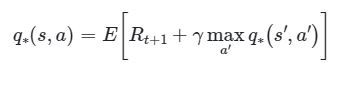

para calcular el valor "real" de `q(s,a)` al que la policy_network debería aspirar. Para calcular `q*(s+1,a*)` usamos la **red externa** del agente. Con eso calculamos el "valor real" `r+ gamma * q*(s+1,a*)`, que es el que luego pasamos a nuestra **policy_network** con un fit (le pasamos el estado s, y este nuevo valor como label).



In [28]:
def learn(agent):
    #If we don't have enough experience yet
    if len(replay_memory) < batch_size:
        return
    
    
    samples = random.sample(replay_memory,batch_size)

    states = []
    newStates=[]
    actions = []
    rewards = []
    terminal = []

    for sample in samples:
        state, action, reward, new_state, done = sample
        states.append(state)
        newStates.append(new_state)
        actions.append(action)
        rewards.append(reward)
        terminal.append(done)

    states = np.array(states).reshape(batch_size,2)
    newStates = np.array(newStates).reshape(batch_size,2)
    actions = np.array(actions).reshape(batch_size)
    rewards = np.array(rewards).reshape(batch_size)
    terminal = np.array(terminal).reshape(batch_size)



    i=0

    Q_values = agent.policy_network(states)
    Q_values = np.array(Q_values)


    #calculamos ajuste para cada (s,a)
    for i in range(batch_size):
        q_s_a = Q_values[i][actions[i]]

        next_q = agent.target_network(newStates[i].reshape(-1,2)
                                     )
        next_q = next_q[0]
        next_q = max(next_q.numpy())


        td_target = (rewards[i]+gamma*next_q)
        
        if terminal[i]:
            td_target = rewards[i]



        Q_values[i][actions[i]] = td_target




    agent.policy_network.fit(states,Q_values,epochs=1,verbose=0)



    
    
    

## 5. Episodio
El episodio es donde el agente acumula experiencia. El episodio comienza, y el agente escoge una **acción**. Esta acción se pasa al ambiente,quien reacciona y regresa un nuevo estado, un reward y una bandera que indica si terminó. La experiencia `(s,a,r,s+1,d)` se guarda en la **replay_memory** que es el repositorio de experiencias pasadas. El episodio regresa el reward total (-199 si nunca terminó, un valor mayor en otro caso) y el número de intervalos de tiempo que pasaron (200 si no acabó, menos si terminó).



En cada timestep de un episodio, llamamos **learn** para que el agente se vaya actualizando

In [29]:
def Episode(agent,current_state,episode_number):
    rewardSum = 0
    max_position = -99
    
    
    for i in range(MAX_STEPS):
        
        #Choose an action
        bestAction = agent.select_action(current_state)
        
        
        #Plot every 50 episodes
        #if episode_number%50 == 0:
            #env.render()
        
        env.render()
        
        #Take action, register new state, reward and if it finished
        new_state,reward,done, _ = env.step(bestAction)
        
        #Reshape new state
        new_state = new_state.reshape(1,2)
        
        
        #Save best effort by agent
        if new_state[0][0] > max_position:
            max_position = new_state[0][0]
            
        
        #If done
        if new_state[0][0] >= 0.5:
                reward += 10
        
        #Save experience
        replay_memory.append([current_state,bestAction,reward,new_state,done])
        
        
        #Replay training
        learn(agent)
        
        rewardSum += reward
        
        current_state = new_state
        
        if done:
            break
    
  
    if (i+1) >= MAX_STEPS:
        print("Failed to finish in episode {}".format(episode_number))
    else:
        print("Succes in episode {}, used {} iterations".format(episode_number,i))

    
    print("now epsilon is {}, the reward is {} maxPosition is {}".format(max(agent.strategy.get_exploration_rate(agent.current_step),agent.strategy.end), rewardSum,max_position))

    return (i,rewardSum)
        
            
            
        
        

## 6. Entrenamiento

Entrenamos al agente corriendo varios episodios. Vamos guardando las duraciones de los episodios y los rewards. Cada cierto número de episodios (`target_update`) copiamos los pesos de la **policy_network** que es la que estamos actualizando constantemente a la **target_network**

In [30]:
def train(agent,num_episodes):
    
    episode_duration = []
    rewards = []
    
    for episode in range(num_episodes):
        current_state = env.reset().reshape(1,2)
        duration,rewardSum = Episode(agent,current_state,episode)
        
        episode_duration.append(duration)
        rewards.append(rewardSum)
        
        if episode%target_update == 0 and episode != 0:
            agent.target_network.set_weights(agent.policy_network.get_weights())
            plot(episode_duration,10)
        
        
    
    return (episode_duration,rewards)
            
    


# Entrenamiento

- batch_size: Tamaño del sample que tomamos del replay memory
- gamma: Tasa de descuento
- eps_start: valor inicial de epsilon
- eps_end: valor más chico de epsilon
- eps_decay: cuánto se reduce epsilon cada timestep
- target_update: cada cuánto se copian los pesos de la policy network a la target network
- graph_update: cada cuántos intervalos copiamos los pesos
- memory_size: cuantas experiencias guardamos (guardamos solo las últimas n experiencias)
- lr: learning rate
- num_episodes: episodios a correrr
- MAX_STEPS: número máximo de steps por episode

### Primer corrida de entrenamiento (400)

In [31]:
batch_size = 60
gamma = 0.99
eps_start = 1
eps_end = 0.01
eps_decay = 0.00005
target_update = 10
graph_update = 10
memory_size = 20000
lr = 0.001
num_episodes = 400
MAX_STEPS = 200

#replay_memory = deque(maxlen=memory_size)

#strategy = EpsilonGreedyStrategy(eps_start,eps_end,eps_decay)

#env = gym.make('MountainCar-v0')

#agent = Agent(strategy,env)

#Corrimos 400 episodios
durations, rewards = train(agent,num_episodes)

Succes in episode 391, used 161 iterations
now epsilon is 0.01, the reward is -152.0 maxPosition is 0.5319553017616272
Failed to finish in episode 392
now epsilon is 0.01, the reward is -200.0 maxPosition is 0.19334232807159424
Failed to finish in episode 393
now epsilon is 0.01, the reward is -200.0 maxPosition is 0.210252046585083
Succes in episode 394, used 169 iterations
now epsilon is 0.01, the reward is -160.0 maxPosition is 0.5187055468559265
Failed to finish in episode 395
now epsilon is 0.01, the reward is -200.0 maxPosition is -0.2898827791213989
Failed to finish in episode 396
now epsilon is 0.01, the reward is -200.0 maxPosition is 0.10822099447250366
Failed to finish in episode 397
now epsilon is 0.01, the reward is -200.0 maxPosition is -0.23348964750766754
Succes in episode 398, used 147 iterations
now epsilon is 0.01, the reward is -138.0 maxPosition is 0.5062853097915649
Succes in episode 399, used 143 iterations
now epsilon is 0.01, the reward is -134.0 maxPosition is

### Segunda corrida de entrenamiento (100)

In [39]:
durations2 =[]
rewards2 =[]

num_episodes = 100

durations2,rewards2 = train(agent,num_episodes)



Failed to finish in episode 91
now epsilon is 0.01, the reward is -200.0 maxPosition is -0.08572857826948166
Succes in episode 92, used 149 iterations
now epsilon is 0.01, the reward is -140.0 maxPosition is 0.5217687487602234
Failed to finish in episode 93
now epsilon is 0.01, the reward is -200.0 maxPosition is -0.18606528639793396
Failed to finish in episode 94
now epsilon is 0.01, the reward is -200.0 maxPosition is 0.37360674142837524
Succes in episode 95, used 135 iterations
now epsilon is 0.01, the reward is -126.0 maxPosition is 0.5015910863876343
Succes in episode 96, used 152 iterations
now epsilon is 0.01, the reward is -143.0 maxPosition is 0.5041264891624451
Succes in episode 97, used 131 iterations
now epsilon is 0.01, the reward is -122.0 maxPosition is 0.5202450752258301
Succes in episode 98, used 145 iterations
now epsilon is 0.01, the reward is -136.0 maxPosition is 0.5140395760536194
Succes in episode 99, used 97 iterations
now epsilon is 0.01, the reward is -88.0 ma

## Resultados

In [58]:

def plot(values,moving_avg_period,label):
    plt.figure(2)
    plt.clf()
    plt.title("Results")
    plt.xlabel("Episode")
    plt.ylabel(label)
    plt.plot(values)
    moving_avg = get_moving_average(moving_avg_period,values)
    plt.plot(moving_avg)
    
    print("Episode",len(values),"\n",moving_avg_period,"Episode moving avg: ",moving_avg[-1])
    
    if is_ipython: display.clear_output(wait=True)

def get_moving_average(period,values):
    values = np.array(values)
    
    if len(values)>= period:
        
        moving_avg = np.cumsum(values)
        moving_avg[period:] = moving_avg[period:]-moving_avg[:-period]
        return moving_avg[period-1:]/period
    else:
        moving_avg = np.zeros(len(values))
        return moving_avg.numpy()
    
    
duraciones = durations + durations2
rewards = rewards + rewards2






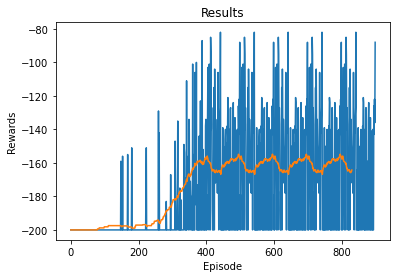

In [59]:
plot(rewards,70,"Rewards")


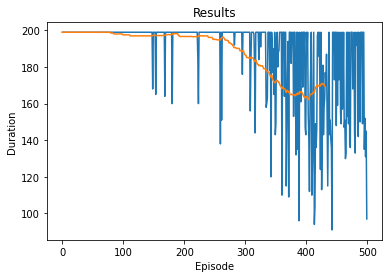

In [60]:
plot(duraciones,70,"Duration")

## Ejemplo

In [131]:
agent.policy_network.save("saved_model/test.h5")

In [88]:
strategy2 = EpsilonGreedyStrategy(0,0,0)

In [138]:

env = gym.make('MountainCar-v0')
num_episodes = 1

agent2 = Agent(strategy2,env)
agent2.policy_network = models.load_model("saved_model/test.h5")


train(agent2,num_episodes)

env.close()

Failed to finish in episode 0
now epsilon is 0, the reward is -200.0 maxPosition is -0.3968026041984558


In [120]:
agent.policy_network.get_weights()

[array([[ 0.33568233,  0.454094  ,  0.12781496,  0.19993992, -0.01136346,
          0.93739253,  0.04015268, -0.11820047, -0.07638507,  1.6601568 ,
          1.1343957 ,  0.01774795, -0.21453115, -0.03891478,  0.30581796,
          0.60014886,  0.09120734, -0.02318881,  0.21029256,  0.05162211,
          0.10901616, -0.66630894,  0.1144265 , -0.03805018],
        [-0.88930434,  6.217512  , -4.889598  , -1.0921044 , -0.69066346,
          6.3804955 ,  0.03297153,  5.026485  , -1.3580936 , -2.0695813 ,
          2.7655973 , -0.01599245, -1.8284786 ,  0.12138858, -2.3936327 ,
          6.6930366 ,  0.12754025,  5.3790402 ,  5.437841  , -1.324453  ,
          0.32398987, -0.22451374,  5.4501147 , -1.9298369 ]],
       dtype=float32),
 array([ 0.41154683, -0.14396365,  0.04964824,  0.18899879,  0.44308442,
        -0.22084136, -0.06245704, -0.23599209,  0.6034067 , -0.11111199,
         0.0220114 , -0.05101116,  0.58625716, -0.06263461,  0.19892555,
        -0.1787913 , -0.08613054, -0.1708

In [128]:
agent2.policy_network.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 24)                72        
                                                                 
 dense_13 (Dense)            (None, 48)                1200      
                                                                 
 dense_14 (Dense)            (None, 3)                 147       
                                                                 
Total params: 1,419
Trainable params: 1,419
Non-trainable params: 0
_________________________________________________________________
